# Lab 9: Audio Classification 

## Part 1: Making a speech detector

In this section we will design a simple classifier that will let us know if its input is speech or non-speech. Download the data archive from: [ https://drive.google.com/file/d/1oAnvk-hzzgzZ4di4W0pKw6v3IWLm9u2X/view?usp=sharing ] In this part we will use the dataset in data/SpeechMusic. In it you will find two directories, speech/ and music/ containing data from each class.

Randomly select 50 soundfiles from each directory to use as training data, and use the remaining sounds as testing data. For all of the sounds we will compute a representation that makes the classification easier and we will use a simple Gaussian model to classify them. Do the following:

- Perform an STFT for each sound, take it’s magnitude and raise it to 0.3 to improve contrast
    - We will consider each spctral slice of that to be a data point
- Using the training data of each sound:
    - Calculate the mean column and the diagonal covariance of the columns
    - You will thus get two sets of Gaussian parameters that model each sound class
- For each testing data point:
    - Calculate the likelihood of each column based on the above models
	- To calculate the entire file likelihood add all the frame likelihoods
	- Assign each soundfile to the class that gets the highest likelihood

For extra credit implement the parameter estimation and model likelihood yourself. If you are too lazy for that you can instead use ```sklearn.mixture.GaussianMixture``` to learn a diagonal single-Gaussian model per class.

How do the results look like? If you rerun this with a different training/testing set, is there an appreciable difference? On average over multiple training/testing sets what accuracy do you get?

In [1]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import numpy as np
import os

In [2]:
# Make a sound player function that plays array "x" with a sample rate "rate", and labels it with "label"
def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    if label is '':
        display( Audio( x, rate=rate))
    else:
        display( HTML( 
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
        '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
        ))
        
def stft( input_sound, dft_size, hop_size, zero_pad, window):
    # Zero padding to front and end of the input
    zero_padding = np.zeros(dft_size)
    x = np.append(zero_padding, input_sound)
    x = np.append(x, zero_padding)

    # Segment into shorter frames
    frames = []
    for i in range(0, len(x)-dft_size, hop_size):
        # Apply analysis window
        frames.append(x[i:i+dft_size] * window)

    f = []
    for frame in frames:
        freq_vec = np.reshape(np.fft.rfft(frame, dft_size+zero_pad), (-1, 1))
        f.append(freq_vec)

    # Return a complex-valued spectrogram (frequencies x time)
    return np.hstack(f)

def istft( stft_output, dft_size, hop_size, zero_pad, window):
    t = []
    for f in stft_output.T:
        t.append(np.fft.irfft(f, dft_size+zero_pad))
    t = np.array(t)

    x = np.zeros(dft_size+hop_size*(len(t)-1))
    for i in range(len(t)):
        x[i*hop_size:i*hop_size+dft_size] += t[i][:dft_size] * window
    
    # Return reconstructed waveform
    return x[dft_size:]

def plot_spectrogram(x, X, fs, title=''):
    time_axis = np.linspace(0, len(x)/fs, X.shape[1])
    freq_axis = np.linspace(0, fs/2, X.shape[0])
    freq_abs = np.absolute(X)

    plt.pcolormesh(time_axis, freq_axis, np.log(freq_abs+np.e), cmap='Blues')

    plt.title(title)
    plt.xlabel('Time (sec)')
    plt.ylabel('Freq (Hz)')

    plt.show()

In [3]:
def get_data_from_dir(dir_path):
    x = []
    for file in os.listdir(dir_path):
        if os.path.isfile(os.path.join(dir_path, file)):
            fs, xi = wavfile.read(os.path.join(dir_path, file))
            x.append(xi)
    return x, fs

def get_stft_features(x):
    X = []
    for xi in x:
        Xi = stft(xi, dft_size, hop_size, zero_pad, stft_window)
        # Take it’s magnitude and raise it to 0.3 to improve contrast
        Xi = np.power(np.abs(Xi), 0.3)
        X.append(Xi)
    return X

def train_test_split(X, train_size):
    X_train, X_test = [], []
    train_index = set(np.random.choice(len(X_speech), size=train_size, replace=False))
    for i in range(len(X)):
        if i in train_index:
            X_train.append(X[i])
        else:
            X_test.append(X[i])
    return X_train, X_test

def get_accuracy():
    true_cnt = 0
    false_cnt = 0

    # Iterate through each sound file
    for X in X_speech_test:
        L_speech = 0
        L_music = 0
        # Accumulate likelihood over all time frames
        for t in range(X.shape[1]):
            L_speech += G_speech.log_likelihood(X[:, t])
            L_music += G_music.log_likelihood(X[:, t])

        if L_speech > L_music:
            true_cnt += 1
        else:
            false_cnt += 1

    # Iterate through each sound file
    for X in X_music_test:
        L_speech = 0
        L_music = 0
        # Accumulate likelihood over all time frames
        for t in range(X.shape[1]):
            L_speech += G_speech.log_likelihood(X[:, t])
            L_music += G_music.log_likelihood(X[:, t])

        if L_music > L_speech:
            true_cnt += 1
        else:
            false_cnt += 1
            
    return true_cnt / (true_cnt + false_cnt)

In [4]:
class SingleGaussian():
    def __init__(self):
        pass
    
    def fit(self, X):
        # Dimension
        self.k = X.shape[0]
        # Number of training data
        self.N = X.shape[1]
        # Mean
        self.m = np.mean(X, axis=1)
        # Covariance
        self.C = 1 / (self.N - 1) * (X - self.m.reshape(-1, 1)) @ (X - self.m.reshape(-1, 1)).T
        # Diagonal covariance 
        self.C = np.diag(np.diag(self.C))
        
        self.C_inv = np.linalg.inv(self.C)
        self.C_det_sign, self.C_logdet = np.linalg.slogdet(self.C)
        
    def log_likelihood(self, x):
        return (-self.k/2) * np.log(2*np.pi) + \
               (-1/2) * self.C_det_sign * self.C_logdet + \
               (-1/2) * (x-self.m).T @ self.C_inv @ (x-self.m)

In [5]:
speech_dir = 'data/SpeechMusic/speech/'
music_dir = 'data/SpeechMusic/music/'

x_speech, fs = get_data_from_dir(speech_dir)
x_music, fs = get_data_from_dir(music_dir)

In [6]:
dft_size = 512
hop_size = 128
zero_pad = 0
stft_window = signal.hann(dft_size, sym=False)

X_speech = get_stft_features(x_speech)
X_music = get_stft_features(x_music)

In [7]:
acc_records = []
# Rerun with random training and testing set
for i in range(10):
    # Split into training set and testing set
    X_speech_train, X_speech_test = train_test_split(X_speech, train_size=50)
    X_music_train, X_music_test = train_test_split(X_music, train_size=50)

    # Treat each spectrum slice as one data point
    X_speech_train = np.hstack(X_speech_train)
    X_music_train = np.hstack(X_music_train)
    
    G_speech = SingleGaussian()
    G_music = SingleGaussian()
    # Train model
    G_speech.fit(X_speech_train)
    G_music.fit(X_music_train)
    
    acc_records.append(get_accuracy())

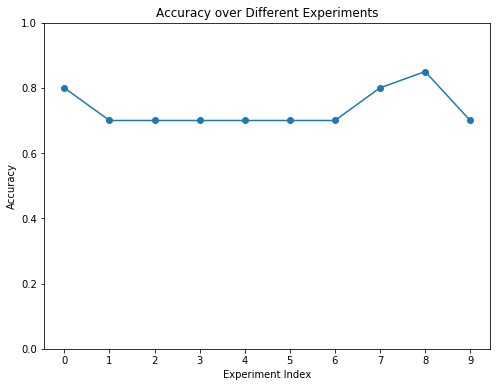

Average accuracy: 0.735


In [8]:
plt.figure(figsize=(8, 6))
plt.plot(acc_records, 'o-')
plt.xticks(range(10))
plt.ylim(0, 1)
plt.title('Accuracy over Different Experiments')
plt.xlabel('Experiment Index')
plt.ylabel('Accuracy')
plt.show()

print(f'Average accuracy: {np.mean(acc_records)}')

## Part 2: Making a music genre classifier

We will repeat the above, but this time we will perform music genre classification. To do so we will use a slightly more elaborate feature representation, and a stronger classification model. If you downloaded the data archive pointed to above, you will find a subset of the CTZAN dataset in the data/genre folder, this is a benchmark data set for music genre classification.

Just as before, you will find a set of directories with examples of each sound class that we want to recognize. For each class, split the soundfiles into a training set (50% of data) and testing set (remaining 50% of data).

For a representation we will use MFCC features. For extra credit, code these yourself otherwise you can use the implementation from the ```librosa``` library. Once all the files are transformed we will have a series of MFCC frames for each recording (as opposed to spectral frames as is in the case of the STFT). We will use these as the data to classify.

For each class learn a Gaussian model (with a diagonal covariance again). This will be the same process as above.
In order to evaluate how good this works we will use the following procedure. For each sound in the training data, get the likelihood of each MFCC frame based on the learned Gaussian models and sum these over the entire file just as we did before. Use the resulting values to get a classification result for each . Report how accurate your results are. Now report the accuracy using your testing data instead.

Now will use a better classifier to hopefully get better accuracy. We will use a Gaussian Mixture Model (```sklearn.mixture.GaussianMixture```). Just as before you should learn one such model for each class using the corresponding training data.

How many Gaussians do you need in your GMM to get the best results? Do the MFCC parameters make a difference? Play around with the numbers to get the best possible results.

In [9]:
import librosa
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings("ignore")

In [10]:
genres_dir = 'data/genres/'

X = defaultdict(list)
genres_map = defaultdict(str)

# Iterate through genre class
for i, genre_dir in enumerate(os.listdir(genres_dir)):
    genres_map[i] = genre_dir
    genre_dir = os.path.join(genres_dir, genre_dir)
    if os.path.isdir(genre_dir):
        # Iterate through sound file
        for file in os.listdir(genre_dir):
            file = os.path.join(genre_dir, file)
            if os.path.isfile(file):
                y, sr = librosa.load(file)
                # Get MFCC
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
                X[i].append(mfccs)

In [11]:
X_train = defaultdict(list)
X_test = defaultdict(list)

for genre in X:
    X_train_genre, X_test_genre = train_test_split(X[genre], test_size=0.5, random_state=42)
    X_train[genre] = X_train_genre
    X_test[genre] = X_test_genre

In [12]:
# Use a Signal Gaussian Model
gmms = defaultdict()

for genre in X_train:
    gmm = GaussianMixture(n_components=1, covariance_type='diag')
    # Treat each time slice at one data point
    X_train_genre = np.hstack(X_train[genre]).T
    gmm.fit(X_train_genre)
    gmms[genre] = gmm

In [13]:
def get_gmm_accuracy(X):
    true_cnt = 0
    false_cnt = 0
    
    for genre in X:
        for Xi in X[genre]:
            y_pred = []
            for gmm_genre in gmms:
                score = gmms[gmm_genre].score(Xi.T)
                y_pred.append(score)
            if np.argmax(y_pred) == genre: # predict value equals to ground truth
                true_cnt += 1
            else:
                false_cnt += 1

    acc = true_cnt / (true_cnt + false_cnt)
    return acc
    print(f'Training set accuracy: {acc}%')

In [14]:
print(f'Training set accuracy: {get_gmm_accuracy(X_train)}')
print(f'Testing set accuracy: {get_gmm_accuracy(X_test)}')

Training set accuracy: 0.8
Testing set accuracy: 0.8


In [15]:
# Use a Gaussian Mixture Model
gmms = defaultdict()

for genre in X_train:
    # More GMM components
    gmm = GaussianMixture(n_components=10, covariance_type='diag')
    X_train_genre = np.hstack(X_train[genre]).T
    gmm.fit(X_train_genre)
    gmms[genre] = gmm

In [16]:
print(f'Training set accuracy: {get_gmm_accuracy(X_train)}')
print(f'Testing set accuracy: {get_gmm_accuracy(X_test)}')

Training set accuracy: 0.936
Testing set accuracy: 0.856


## Part 3: Make it better (extra credit, required for 4-hour registrants)

There is no shortage of techniques (and free code) to use for classification. Revisit the two problems above and use any other type of classifier you want (Neural Nets, Boosting, Decision Trees, whatever). Also feel free to use any feature you want. Can you improve on the results you got before? How much higher can you get your accuracy for either case?

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [18]:
X_clf = []
y_clf = []
for genre in X:
    for x in X[genre]:
        for t in range(x.shape[1]):
            X_clf.append(x[:, t])
            y_clf.append(genre)

In [19]:
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf, y_clf, test_size=0.5, random_state=42)

In [20]:
clf = DecisionTreeClassifier()
clf.fit(X_clf_train, y_clf_train)
print(f'Accuracy: {clf.score(X_clf_test, y_clf_test)}')

Accuracy: 0.7070034734357941
